In [1]:
from model import *

2025-01-22 09:30:06.058597: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737534606.069669  255017 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737534606.073074  255017 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-22 09:30:06.084477: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
state = State.load(Path('Glow2d_mnist.pth'))
model = state.model

/users/nfs/Etu6/21322736/ADL/Normalizing flows/model.py:297: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(fp, map_location=DEVICE)
INFO:root:Starting bac

In [3]:
test_mnist = torchvision.datasets.MNIST(
    root='./mnist_data/',
    transform=transforms.Compose([transforms.Resize(32),
                                  transforms.ToTensor(),
                                 ]),
    train=False,
    download=True,
)

In [4]:
from collections import defaultdict
samples_collect = defaultdict(list)

In [5]:
for image, label in test_mnist:
    if len(samples_collect[label]) < 2:
        samples_collect[label].append(image)
    
    if all(len(samples) == 2 for samples in samples_collect.values()) and len(samples_collect) == 10:
        break

In [6]:
samples_collect = dict(sorted(samples_collect.items()))

In [7]:
for label, images in samples_collect.items():
    print(f"Label: {label}, Number of samples: {len(images)}")

Label: 0, Number of samples: 2
Label: 1, Number of samples: 2
Label: 2, Number of samples: 2
Label: 3, Number of samples: 2
Label: 4, Number of samples: 2
Label: 5, Number of samples: 2
Label: 6, Number of samples: 2
Label: 7, Number of samples: 2
Label: 8, Number of samples: 2
Label: 9, Number of samples: 2


In [8]:
alphas = torch.linspace(0., 1., 10)

In [9]:
interpolations = torch.zeros((10, len(alphas), 1, 32, 32))
for label, images in samples_collect.items():
    latents_interpolation = []
    zs1, _, _ = model.encoder(preprocess(images[0].to(DEVICE)).unsqueeze(0)) 
    zs2, _, _ = model.encoder(preprocess(images[1].to(DEVICE)).unsqueeze(0)) 
    for i, alpha in enumerate(alphas):
        zs_interpolation = [alpha*zs1[j] + (1.-alpha)*zs2[j] for j in range(len(zs1))]
        img_inter = model.reconstruct(zs_interpolation).squeeze(0).detach().cpu()
        interpolations[int(label), i] = postprocess(img_inter)

In [10]:
img_grid = vutils.make_grid(interpolations.reshape(-1, 1, 32, 32), normalize=True, scale_each=True, nrow=10).permute(1, 2, 0).numpy()

In [11]:
import matplotlib.pyplot as plt

(-0.5, 341.5, 341.5, -0.5)

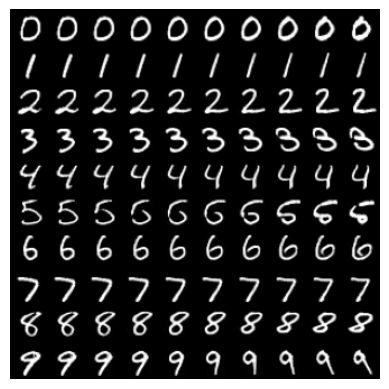

In [12]:
plt.imshow(img_grid) 
plt.axis('off')